# About 📌 📎

**Language Modeling is the task of predicting what word comes next.**

**Language Modeling** is a subcomponent of many NLP tasks, especially those involving generating text or estimating the probability of text:

- Predictive typing in smartphones
- Spelling correction: P(about fifteen minutes from) > P(about fifteen minuets from)
- Speech recognition: P(I saw a van) > P(eyes awe of an); given a speech signal, what is the corresponding text.
- Authorship identification: who wrote some sample text
- Machine translation: P(high winds tonight) > P(large winds tonight); generating output text of a language conditioned on an input sentence of another language.
- Dialogue bots


In this notebook, I use the dataset of **New York Times Comments and Headlines** to train a text generation language model that can generate new headlines based on a given prompt. 

The notebook provides a step-by-step guide to build and test the model, as well as examples of generated headlines. It's a great example of how NLP can be used to generate creative and engaging content.


**So, let’s get started. 🏃🏽‍♀️ 🏃🏽‍♀️**

# Import Libs 🔨 🛠️ 🔧

In [1]:
import tensorflow as tf
import pandas as pd
import os , string , sys , numpy, spacy , nltk, re, random, timeit
import numpy as np 
import matplotlib.pyplot as plt
from spacy import displacy
import plotly.express as px

from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Data 🔋 🛒🛒

In [2]:
working_dir = '../input/nyt-comments/'
headlines = []

for filename in os.listdir(working_dir):
    if 'Articles' in filename:
        article_df = pd.read_csv(working_dir + filename)
        headlines.extend(list(article_df.headline.values))

all_headlines = [x for x in headlines if x!="Unknown"]
all_headlines = headlines



In [3]:
len(headlines)

9335

**💡 We have a total of (9335) headlines.**

In [4]:
#check first 10 headlines
headlines[:10]

['N.F.L. vs. Politics Has Been Battle All Season Long',
 'Voice. Vice. Veracity.',
 'A Stand-Up’s Downward Slide',
 'New York Today: A Groundhog Has Her Day',
 'A Swimmer’s Communion With the Ocean',
 'Trail Activity',
 'Super Bowl',
 'Trump’s Mexican Shakedown',
 'Pence’s Presidential Pet',
 'Fruit of a Poison Tree']

# Explore & Visualize Data 🧐 🔍 📈 📊

In [5]:
#map list of strings to one string , so we can analyze frequent words
full_txt = " ".join(map(str, headlines))

#### Wondering which words the most used for Headlines? 🧐🧐

In [6]:
nlp = spacy.load('en_core_web_sm')
stopword = nltk.corpus.stopwords.words('english')
def text_cleaning(text):
    
    text = re.sub(r'[^\w\s]', '',str(text))             #Punctuations
    text=re.split("\W+",text)                           #Tokenizing
    text=[word for word in text if word not in stopword]#Stop words
    text = ' '.join(text)                              
    return text


def frequent_of_words(string):
    
    clean_string = text_cleaning(string)
    split_string = pd.DataFrame(clean_string.split(),columns=['Words'])
    split_string = split_string.value_counts()[:1000].reset_index(drop=False)[:1000]
    split_string.columns = ['Words','Count']
    return split_string

frequent_words = frequent_of_words(full_txt )
frequent_words[:15].style.background_gradient(cmap='Blues')

,Words,Count
0,The,966
1,Unknown,733
2,A,705
3,Is,586
4,Trump,549
5,With,403
6,New,337
7,How,283
8,In,279
9,What,267


In [7]:
fig = px.funnel(frequent_words[:15], x='Count', y='Words')
fig.show()

**💡 Inference** We can see that many of the frequent words are stopwords that should be eleminated  but somehow stopwords failed to catch.

#### Which Political charachter were most mentioned in the news?! 🧐🧐

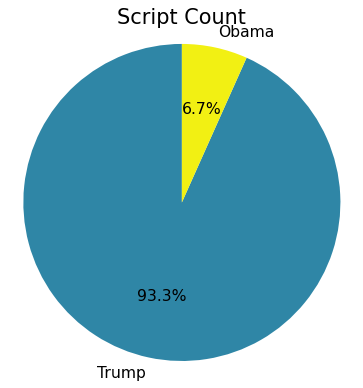

In [8]:
name_list = ['Trump','Obama']
scripts = []
split_string = full_txt.split()
for name in name_list:
    scripts.append((name,split_string.count(name)))
    
# Visualization    
colors = ['#2F86A6','#F2F013']
sections = [scripts[0][1],
            scripts[1][1],
]
plt.figure(figsize=(6, 6), dpi=75)
plt.pie(sections, labels=name_list,colors=colors, 
        wedgeprops=dict( alpha=1),
        startangle=90,
        #explode = (0,0,0,0),
        autopct = '%0.1f%%',
         textprops={
                'fontsize': 15, 
                'fontweight': 'normal'}
            )

plt.axis('equal')
plt.title('Script Count',fontsize=20)
plt.show()

**Inference 💡**  Sadly, Obama lost this time :(

## Text pre-processing 📜 ,👀, 📊

In [9]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 


In [10]:

#Apply function clean_txt on headlines
print ('BEFORE .. \n',headlines[0])
corpus = [clean_text(x) for x in headlines]
print ('\n AFTER .. \n ',headlines[0])

BEFORE .. 
 N.F.L. vs. Politics Has Been Battle All Season Long

 AFTER .. 
  N.F.L. vs. Politics Has Been Battle All Season Long


# Tokenization 🧮🗃 

- The process of splitting paragraphs and sentences into smaller units that can be more easily assigned meaning.
- The first step of the NLP process is gathering the data (a sentence) and breaking it into understandable parts (words).

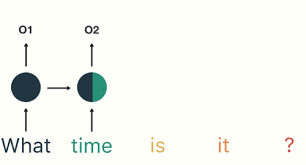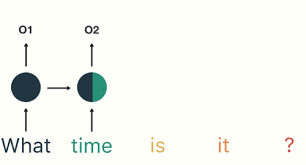

In [11]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

# print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')


total words: 11265


 **Inference 💡** We can see a total of (11256) samples are created.

In [12]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:
	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]
	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):
		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]
		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)


# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])


# Pad all sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))


# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]


# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [13]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []


# Look up the indices of each word and append to the list
for word in sentence: 
    print(word)
    token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)

sample sentence: ['nfl', 'vs', 'politics', 'has', 'been', 'battle', 'all', 'season', 'long']
nfl
vs
politics
has
been
battle
all
season
long
[916, 149, 213, 74, 476, 203, 69, 29, 183]


Since there are **9 tokens** here, we can expect to find this particular line in the **first 8 elements** of the xs that we  generated earlier.

 If we get the longest subphrase generated, that should be found in **xs[8]**. See the padded token sequence below:

In [14]:
# Pick element
elem_number = 7

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')


token list: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 916 149 213
  74 476 203  69  29]
decoded to text: ['nfl vs politics has been battle all season']


If you print out the label, it should show **183** because that is the next word in the phrase (i.e. **long**). 


In [15]:
# We use the folling code in order to print the full numby array without truncate
numpy.set_printoptions(threshold=sys.maxsize)

#disply label one-hot code and value
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

one-hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## Build Model 👨‍🔧🔧 

We are going to build a simple model,

- The `Embedding layer` maps input information from a high-dimensional to a lower-dimensional space, allowing the network to learn more about the relationship between inputs and to process the data more efficiently. 

There are three parameters to the embedding layer

        1- input_dim : Size of the vocabulary (total_words)
        2- output_dim : Length of the vector for each word (embedding_dim)
        3- input_length : Maximum length of a sequence

- The `Bidirectional LSTMs` layer is used to train two sides, instead of one side of the input sequence. First from left to right on the input sequence and the second in reversed order of the input sequence. It provides one more context to the word to fit in the right context from words coming after and before, this results in faster and fully learning and solving a problem 

- The `Output layer` is a a softmax activated `Dense` layer that have one neuron for each word in the vocabulary. So given an input token list, the output array of the final layer will have the probabilities for each word.


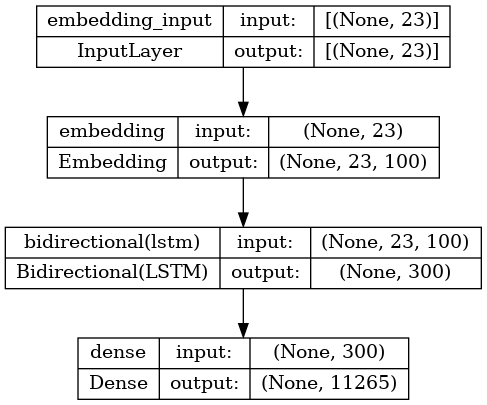

In [16]:
# Hyperparameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build the model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

# Print the model summary

keras.utils.plot_model(model,show_shapes=True)

## Train model ⚗️ 🌡 👩‍🔬

We can now train the model. We have a relatively a little large vocabulary so it will only take a couple of minutes to complete number of epochs. ⌛️ ⏳

In [17]:
# Train the model
history = model.fit(xs, ys, epochs=100)

Epoch 1/100
1618/1618 [==============================] - 40s 19ms/step - loss: 7.7705 - accuracy: 0.0672
Epoch 2/100
1618/1618 [==============================] - 18s 11ms/step - loss: 6.7236 - accuracy: 0.1121
Epoch 3/100
1618/1618 [==============================] - 18s 11ms/step - loss: 5.6803 - accuracy: 0.1494
Epoch 4/100
1618/1618 [==============================] - 17s 11ms/step - loss: 4.6942 - accuracy: 0.2030
Epoch 5/100
1618/1618 [==============================] - 18s 11ms/step - loss: 3.9920 - accuracy: 0.2661
Epoch 6/100
1618/1618 [==============================] - 18s 11ms/step - loss: 3.5351 - accuracy: 0.3179
Epoch 7/100
1618/1618 [==============================] - 17s 11ms/step - loss: 3.2110 - accuracy: 0.3517
Epoch 8/100
1618/1618 [==============================] - 18s 11ms/step - loss: 2.9799 - accuracy: 0.3829
Epoch 9/100
1618/1618 [==============================] - 17s 10ms/step - loss: 2.8207 - accuracy: 0.4052
Epoch 10/100
1618/1618 [==============================]


- We can notice **Ups and Downs ↗️ ↘️** at the Acc & Loss  values , which will be represeneted as **jaggedness〰️** in Acc & Loss curve

# Visualize Results 📈 📉 📊

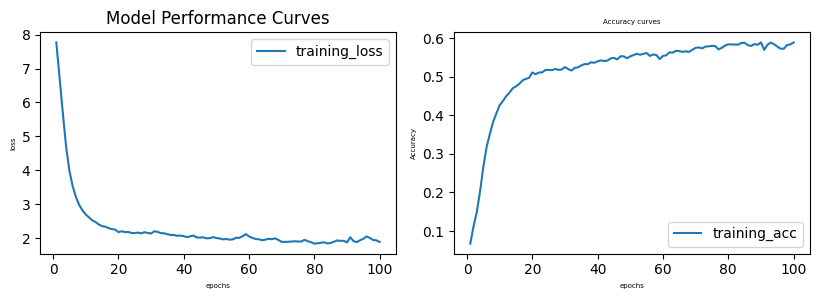

In [18]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    train_loss=history.history['loss']

    train_accuracy=history.history['accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(8,3))

    # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.title("Accuracy curves",size=5)
    plt.xlabel('epochs',size=5)
    plt.ylabel('Accuracy',size=5)
    plt.tight_layout()
    plt.legend(fontsize=10);


    # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.title("Loss curves",size=5)
    plt.xlabel('epochs',size=5)
    plt.ylabel('loss',size=5)
    plt.legend(fontsize=10);
    # plt.show()

    plt.title('Model Performance Curves')
    
plot_loss_curves(history)
     
    

**Inference 💡** 

Let's agree that the **jaggedness** in Acc curve can be an indication that the model needs improvement, and the single LSTM that we can see here is not the smoothest. 

If we look at loss, over the first 20 epochs, we can see similar results. But look what happens when we increase to 25 epochs training. Our one layer LSTM, while climbing in accuracy, is also prone to some pretty sharp dips. The final result might be good, but those dips makes us suspicious about the overall accuracy of the model. 
 
**The more smoother is the curve, the more we confident in its results.**

 So a bit of tweaking to the LSTM should help fix that.


# Test Model - Generating Text

**Let the Magic Begin !! 🔮 ✨**



With the model trained, we can now use it to make its own Headline! The process would look like:

1. Feed a seed text to initiate the process.
2. Model predicts the index of the most probable next word.
3. Look up the index in the reverse word index dictionary
4. Append the next word to the seed text.
5. Feed the result to the model again.

Steps 2 to 5 will repeat until the desired length of the song is reached. 

In [19]:
def expect_next_sequence (seed_text ,next_words ):
        # Loop until desired length is reached
    for _ in range(next_words):

        # Convert the seed text to a token sequence
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad the sequence
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        # Feed to the model and get the probabilities for each index
        probabilities = model.predict(token_list)

        # Get the index with the highest probability
        predicted = np.argmax(probabilities, axis=-1)[0]

        # Ignore if index is 0 because that is just the padding.
        if predicted != 0:

            # Look up the word associated with the index. 
            output_word = tokenizer.index_word[predicted]

            # Combine with the seed text
            seed_text += " " + output_word

        # Print the result	
        print(seed_text)

In [35]:

seed_text = 'White House Will'
next_words = 5
expect_next_sequence(seed_text ,next_words)


1/1 [==============================] - 0s 26ms/step
White House Will sign
1/1 [==============================] - 0s 28ms/step
White House Will sign for
1/1 [==============================] - 0s 26ms/step
White House Will sign for legal
1/1 [==============================] - 0s 24ms/step
White House Will sign for legal drugs
1/1 [==============================] - 0s 33ms/step
White House Will sign for legal drugs on


In the output above, we might notice **frequent repetition** of words the longer the sentence gets. There are ways to get around it and the next cell shows one. 

Basically, instead of getting the index with **max probability**, we can get the top three indices and choose one at random. See if the output text makes more sense with this approach. This is not the most time efficient solution because it is always sorting the entire array even if you only need the top three.

In [21]:
def expect_next_sequence_max_probability (seed_text ,next_words ):

    # Loop until desired length is reached
    for _ in range(next_words):

        # Convert the seed text to a token sequence
      token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad the sequence
      token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

        # Feed to the model and get the probabilities for each index
      probabilities = model.predict(token_list)

      # Pick a random number from [1,2,3]
      choice = np.random.choice([1,2,3])

      # Sort the probabilities in ascending order 
      # and get the random choice from the end of the array
      predicted = np.argsort(probabilities)[0][-choice]

        # Ignore if index is 0 because that is just the padding.
      if predicted != 0:

            # Look up the word associated with the index. 
          output_word = tokenizer.index_word[predicted]

            # Combine with the seed text
          seed_text += " " + output_word
      # Print the result	
      print(seed_text)


In [41]:

expect_next_sequence_max_probability(seed_text ,next_words)

1/1 [==============================] - 0s 25ms/step
White House Will sign
1/1 [==============================] - 0s 23ms/step
White House Will sign of
1/1 [==============================] - 0s 22ms/step
White House Will sign of letting
1/1 [==============================] - 0s 22ms/step
White House Will sign of letting on
1/1 [==============================] - 0s 24ms/step
White House Will sign of letting on obamacare


# Wrap Up 🏷️ 📚 🛎️

In this notebook, I build a simple text generation model, yet the results can be improved further with following points:

- Adding more data
- Tweaking the hyperparameters
- Fine Tuning the network architecture
- Fine Tuning the network parameters



# Refrences 🗺️ 💎 

[NLP in TensorFlow | Coursera ](https://www.coursera.org/learn/natural-language-processing-tensorflow)

[Friends - Text GeneratorFriends - Text Generator | Kaggle](https://www.kaggle.com/code/mammadabbasli/friends-text-generatorhttps://www.kaggle.com/code/mammadabbasli/friends-text-generator)

[Beginners Guide to Text Generation using LSTMs | Kaggle](https://www.kaggle.com/code/aggarwalrahul/nlp-lstm-text-generation-beginner-guidehttps://www.kaggle.com/code/aggarwalrahul/nlp-lstm-text-generation-beginner-guide)

[Neural Language Models (NLM) | LinkedIn](https://www.linkedin.com/pulse/neural-language-models-nlm-without-pain-ibrahim-sobh-phd/)

**🎀 Thanks , Any Comments will be welcomed 🎀**